In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from matplotlib.colors import LogNorm

import seaborn as sns 
import tables 
import pickle
import warnings
import iminuit as mi
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d

warnings.filterwarnings(action='once')
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365*5 # 1 year!  # independent of eff area calculation and subsedquent asimov test
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-3-2-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


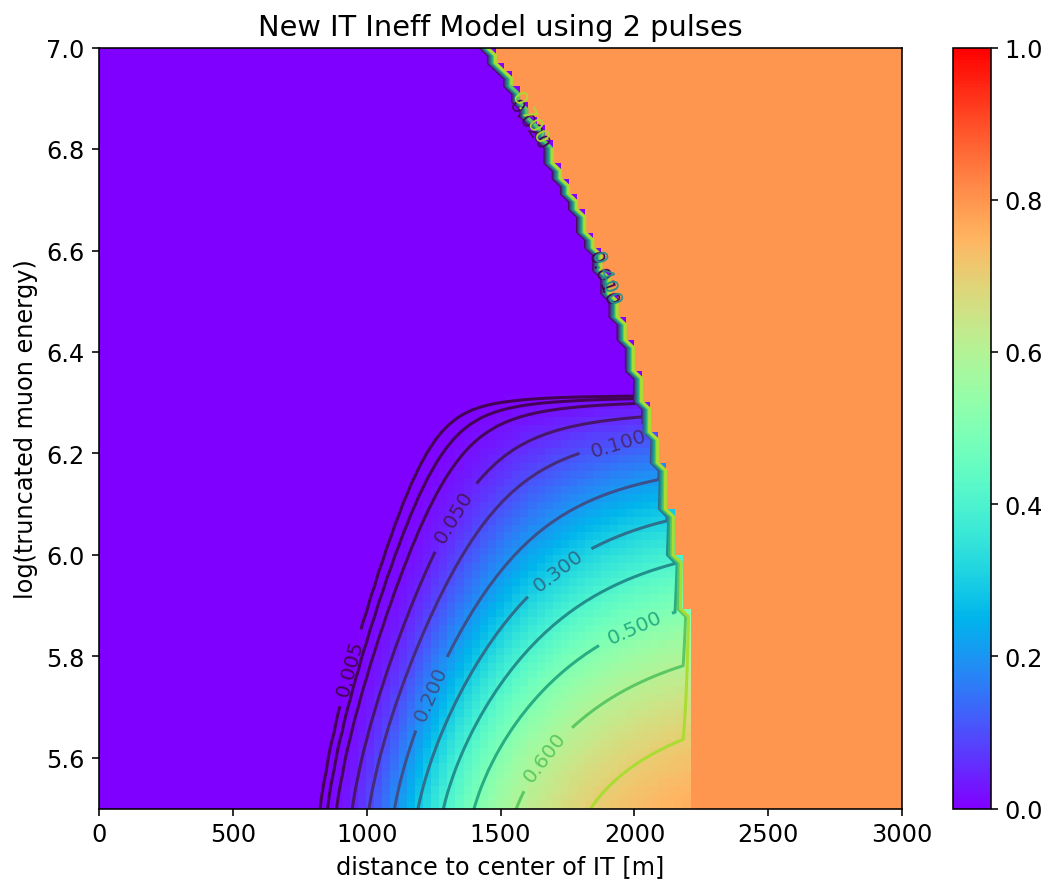

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]
    
#     val = a * 1 / (1+np.exp(-(dist/2000-b)/c))
    val = a * np.exp(-b/(dist/2000)**(4.5))

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
with tables.open_file(data_dir+'corsika_h5/corsika_combined.h5','r') as f:

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < 0.094
    
    CUT_SIGNAL = np.log10(f.root.Collection.cols.chi2_red_new[:]) > -10 #2.5
    
    CUT_goodweight = f.root.Combined_Weight_H3a[:] > 0
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff & CUT_goodweight & CUT_SIGNAL
    
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_corsika = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_corsika = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_corsika = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_corsika = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    Qtot_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_corsika = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_corsika = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_corsika = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_corsika = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_corsika = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_corsika = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_corsika = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_corsika = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_corsika = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_corsika = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_corsika = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_corsika = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_corsika = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    E_bundle_corsika = f.root.Bundle.cols.MuonBundleEnergy_Ei[:][CUT]
    E_leading_muon_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness_Ei[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size_Ei[:][CUT]
    xf_corsika = E_bundle_corsika/prim_e_corsika
    E_shower_corsika = prim_e_corsika - E_bundle_corsika # surface shower
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    A_corsika = f.root.PolyplopiaPrimary.cols.type[:][CUT]

    weight_corsika = f.root.Combined_Weight_H3a[:][CUT] * lifetime * ineff_[CUT]

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [6]:
with tables.open_file(data_dir+'nugen_h5/nugen_20878.h5','r') as f:
    n_file = 10000

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < 0.094
    
    CUT_SIGNAL = np.log10(f.root.Collection.cols.chi2_red_new[:]) > -10 #2.5

    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff & CUT_SIGNAL
    
    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_numu = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_numu = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    # astrophysical #
    energy = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    # atmospheric 
    
    weight_numu_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 
    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


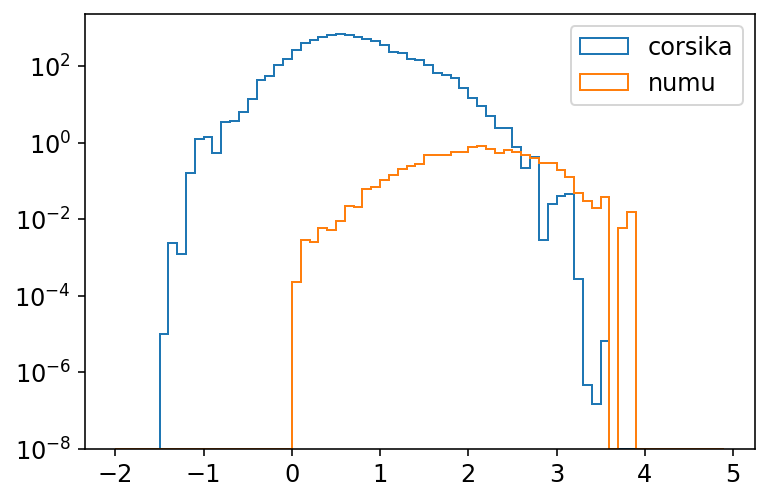

In [7]:
h,b,_ = plt.hist(np.log10(chi2_red_new_corsika),weights=weight_corsika,histtype='step',log=True,bins=np.arange(-2,5,0.1),label='corsika',bottom=1e-8)
hh,bb,_= plt.hist(np.log10(chi2_red_new_numu),weights=weight_numu_astro,histtype='step',log=True,bins=np.arange(-2,5,0.1),label='numu',bottom=1e-8)
plt.legend()
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/yang/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


(-8, 8)

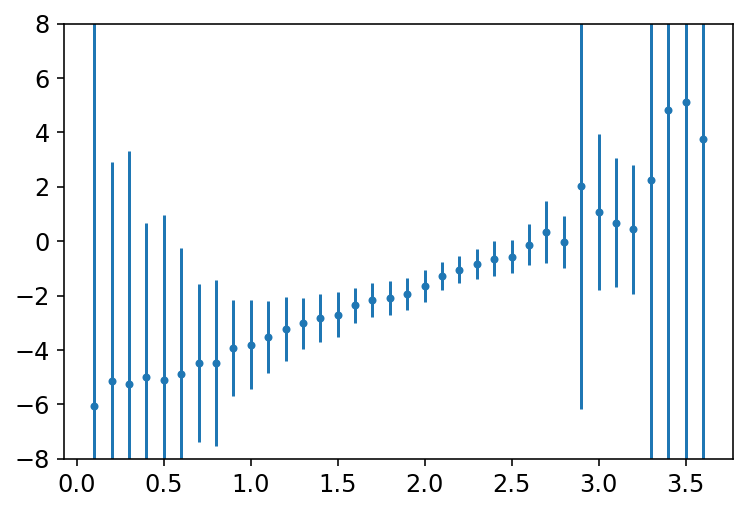

In [8]:
def sigma(x,y): # log10(x/y)
    return 1/np.log(10) * np.sqrt(1/x+1/y)

plt.errorbar(x=b[1:],y=np.log10(hh/h),fmt='.',yerr=sigma(hh,h))
# plt.xlim(0,3.5)
plt.ylim(-8,8)